In [1]:
from lookahead_pytorch import Lookahead
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn 
import torch.nn.functional as F

import torch 
import torchbearer

In [2]:
trainset = datasets.MNIST(".", train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(".", train=False, download=True, transform=transforms.ToTensor())

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
valloader = DataLoader(testset, batch_size=128, shuffle=True)

0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to .\MNIST\raw\train-images-idx3-ubyte.gz
 85%|████████▍ | 8380416/9912422 [00:43<00:00, 1954414.56it/s]Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw

0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to .\MNIST\raw\train-labels-idx1-ubyte.gz
9920512it [01:00, 1954414.56it/s]
 57%|█████▋    | 16384/28881 [00:42<00:00, 159211.80it/s]

0it [00:00, ?it/s]Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw

32768it [00:56, 159211.80it/s]

  0%|          | 0/1648877 [00:42<?, ?it/s]

  1%|          | 16384/1648877 [00:42<00:12, 127224.83it/s]

  3%|▎         | 49152/1648877 [00:42<00:10, 155644.54it/s]

  6%|▌         | 98304/1648877 [00:42<00:07, 194752.87it/s]

 14%|█▍        | 229376/1648877 [00:42<00:05, 261435.36it/s]

 29%|██▉       | 483328/1648877 [00:42<00:03, 357635.82it/s]

 36%|███▋      | 598016/1648877 [00:42<00:02, 4

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 30, (5, 5), padding=0)
        self.conv2 = nn.Conv2d(30, 15, (3, 3), padding=0)
        self.fc1 = nn.Linear(15 * 5**2, 128)
        self.fc2 = nn.Linear(128, 50)
        self.fc3 = nn.Linear(50, 10)
    
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, (2,2))
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, (2,2))
        out = F.dropout(out, 0.2)      
        out = out.view(out.shape[0], -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        return self.fc3(out)

In [4]:
device = "cuda:0"


results = []

# Adam + Lookahead
model = CNN()
loss_function = nn.CrossEntropyLoss()
opt = Lookahead(torch.optim.Adam(model.parameters()))

trial = torchbearer.Trial(model, opt, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader, val_generator=valloader)
results.append(trial.run(epochs=10))


# Adam 
model = CNN()
loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

trial = torchbearer.Trial(model, opt, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader, val_generator=valloader)
results.append(trial.run(epochs=10))

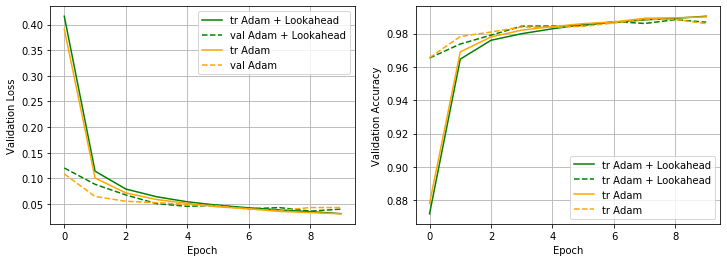

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
labels = ['Adam + Lookahead', 'Adam']
colors = ['green', 'orange']
for result, label, color in zip(results, labels, colors):
    ax[0].plot(pd.DataFrame(result)['loss'], label='tr '+label, c=color)
    ax[0].plot(pd.DataFrame(result)['val_loss'], label='val '+label, c=color, linestyle='dashed')
    ax[1].plot(pd.DataFrame(result)['acc'], label='tr '+label, c=color)
    ax[1].plot(pd.DataFrame(result)['val_acc'], label='tr '+label, c=color, linestyle='dashed')

ax[0].set_ylabel("Validation Loss")
ax[1].set_ylabel("Validation Accuracy")
ax[0].set_xlabel("Epoch")
ax[1].set_xlabel("Epoch")

ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()